# Explore whether the Zillow Data has the accurate substation attached

The substation attachment to the Zillow house data was completed before the  start of this project. This repository explores the accuracy of the pre-assingments. The pre-assignments are also in a csv as opposed to in the geo-spatial format. This repository also explores any potential differences between the csv data and the geo-spatial Zillow data. 

In [15]:
# load necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point # to make the lat and long of the zillow data into a gpd object
from shapely.geometry import box  # To create polygon bounding box
import glob
import folium

In [3]:
# SDGE substation polygons
sdge_substations = gpd.read_file("../../../../capstone/electrigrid/data/utilities/sandiego_grid/substation_sdge.geojson")

In [5]:
# read in the zillow geo data 
zillowmap = gpd.read_file("../../../../capstone/electrigrid/data/buildings/final_zillow.gpkg")

In [24]:
zillowmap.head()

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,geometry
0,Multi,2003.0,1.0,None,None,I,224.0,491943.0,living,1003.0,3,06001403302,468,PGE/SCE,RR106,POINT (564447.371 4183243.435)
1,Multi,2003.0,1.0,None,None,None,224.0,240117.0,living,936.0,4,06001403302,468,PGE/SCE,RR106,POINT (564447.371 4183243.435)
2,Multi,2003.0,1.0,None,None,I,224.0,261770.0,living,997.0,5,06001403302,468,PGE/SCE,RR106,POINT (564447.371 4183243.435)
3,Multi,2003.0,1.0,None,None,None,224.0,223337.0,living,1002.0,6,06001403302,468,PGE/SCE,RR106,POINT (564447.371 4183243.435)
4,Multi,2003.0,1.0,None,None,None,224.0,241347.0,living,1003.0,7,06001403302,468,PGE/SCE,RR106,POINT (564449.237 4183218.817)


**Note: Zillow geo-spatial data takes 12 minutes to load with subpar internet**

In [13]:
# read in zillow csv
zillow_sub_data = pd.read_csv("../../../../capstone/electrigrid/data/buildings/zillow_cats_ica_joined.csv")

In [14]:
zillow_sub_data.head()

,bus_i,kV,Type,Sub,p_ID,area,GEOID,ID,X,Y
0,1.0,115.0,'Substation',jenney,h1334,Others,6.001427e+09,1746.0,-122.242977,37.772369
1,2.0,66.0,'Substation',NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,66.0,'Substation',NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,230.0,'Substation',castro valley,167,PGE/SCE,6.001431e+09,153.0,-122.061266,37.691784
4,5.0,115.0,'Substation',jarvis,67,PGE/SCE,6.001440e+09,65.0,-122.017544,37.595334


### Convert the Zillow csv to gpd

In [16]:
geo_zillow_sub  = gpd.GeoDataFrame(
    zillow_sub_data, 
    geometry=gpd.points_from_xy(zillow_sub_data.X, zillow_sub_data.Y),
    crs='EPSG:4326'
)

In [17]:
geo_zillow_sub.head()

,bus_i,kV,Type,Sub,p_ID,area,GEOID,ID,X,Y,geometry
0,1.0,115.0,'Substation',jenney,h1334,Others,6.001427e+09,1746.0,-122.242977,37.772369,POINT (-122.24298 37.77237)
1,2.0,66.0,'Substation',NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (nan nan)
2,3.0,66.0,'Substation',NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (nan nan)
3,4.0,230.0,'Substation',castro valley,167,PGE/SCE,6.001431e+09,153.0,-122.061266,37.691784,POINT (-122.06127 37.69178)
4,5.0,115.0,'Substation',jarvis,67,PGE/SCE,6.001440e+09,65.0,-122.017544,37.595334,POINT (-122.01754 37.59533)



### Clip the Zillow data using the San Diego Substation polygons

First check the CRS.

In [6]:
sdge_substations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
zillowmap.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
geo_zillow_sub.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
# change the crs to the crs of the sd data 
sd_zillow = zillowmap.to_crs('EPSG:4326')

assert sdge_substations.crs == sd_zillow.crs
assert sdge_substations.crs == geo_zillow_sub.crs

In [20]:
# clip the zillow data using the san diego
sd_zillow = gpd.clip(sd_zillow, sdge_substations)
sub_sd_zillow = gpd.clip(geo_zillow_sub, sdge_substations)


In [25]:
sd_zillow.head()

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,geometry
7969668,Single,2002.0,2.0,None,None,O,1.0,371922.0,living,2145.0,8342100,06073021102,h210,SDGE,RR101,POINT (-116.19624 32.61295)
7969670,Multi,1950.0,8.0,None,None,O,3.0,335654.0,living,3465.0,8342102,06073021102,h210,SDGE,RI110,POINT (-116.19786 32.61334)
7969769,Single,1995.0,3.0,None,None,O,1.0,145351.0,living,2368.0,8342209,06073021102,h210,SDGE,RR103,POINT (-116.19154 32.61354)
7969669,Single,1980.0,2.0,None,None,None,1.0,52680.0,living,640.0,8342101,06073021102,h210,SDGE,RR101,POINT (-116.20579 32.61364)
7969770,Single,1935.0,3.0,None,None,None,1.0,283816.0,living,1505.0,8342210,06073021102,h210,SDGE,RR101,POINT (-116.18848 32.61367)


## Plot the Zillow points from the geo package and the csv


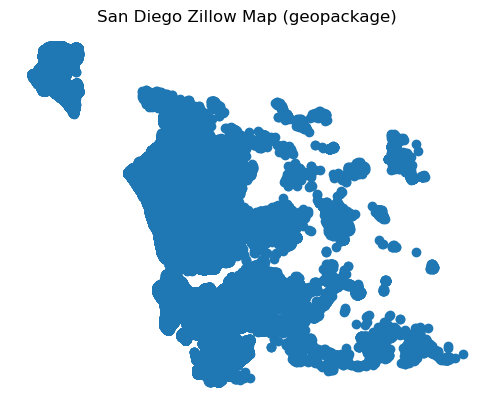

In [ ]:
# initial plot of san diego zillow points from the geopackage
fig, ax = plt.subplots()

sd_zillow.plot(ax=ax)

ax.set_title('San Diego Zillow Map (geopackage)')
ax.axis('off')

plt.show()

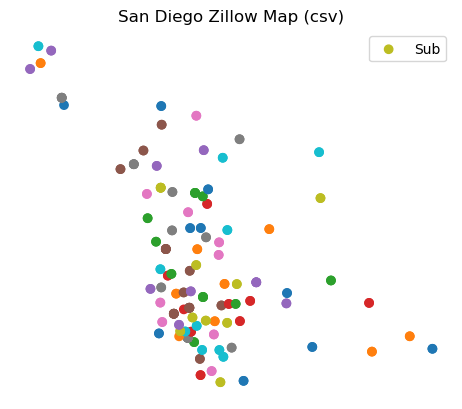

In [35]:
# initial plot of san diego zillow points from the csv
fig, ax = plt.subplots()

sub_sd_zillow.plot(column = 'Sub',
                  label = 'Sub',
    ax=ax)

ax.set_title('San Diego Zillow Map (csv)')
ax.axis('off')


# add legend 
ax.legend()

plt.show()